# Qwen_2.5 Fine-tuning for text classification using LORA


### Requirements:
* A GPU with enough memory!

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

## Installing necessary libraries

In [ ]:
import torch, numpy, pandas, scipy
print("torch:", torch.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("scipy:", scipy.__version__)

torch: 2.9.0+cpu
numpy: 2.0.2
pandas: 2.2.2
scipy: 1.16.3


In [1]:
%pip install --upgrade \
  transformers>=4.56.1 \
  datasets>=2.18.0 \
  accelerate>=0.30.1 \
  evaluate \
  huggingface_hub \
  peft==0.18.1 \
  trl==0.28.0 \
  bitsandbytes \
  langchain \
  langchain-community \
  tensorboard


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
tensorflow 2.19.0 requires tensorboard~=2.19.0, but you have tensorboard 2.20.0 which is incompatible.


In [2]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 9.4 MB/s eta 0:00:00


### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Login to huggingface hub to put your LLama token so we can access QWEN 2.5 1.5B Param Pre-trained Model

In [4]:
from google.colab import userdata
import wandb
from huggingface_hub import login

wandb.login(key=userdata.get('wandb'))
hf_token = userdata.get('Hf_token')

try:
    login(token=hf_token)
    print("Hugging Face Hub login successful!")
except Exception as e:
    print(f"Error during Hugging Face Hub login: {e}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yehiamagdy9 (yehiamagdy9-alexandria-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Hugging Face Hub login successful!


###### Imports

## Importing necessary libraries

In [5]:
import os
import random
import functools
from groq import Groq
from tqdm import tqdm
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate # This import will work after fixing torch/torchvision versions
from trl import SFTConfig, SFTTrainer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from google.colab import userdata

from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    AutoModelForCausalLM,
    DataCollatorWithPadding
)
from datasets import load_dataset
import pandas as pd
from langchain_community.document_loaders.dataframe import DataFrameLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


### Loading dataset from huggingface


In [ ]:
class StoryDatasetLoader:
    def __init__(self, dataset_name="FareedKhan/1k_stories_100_genre", columns=None):
        if columns is None:
            columns = ["id", "title", "story", "genre"]
        self.dataset_name = dataset_name
        self.columns = columns
        self.df = pd.DataFrame()
        self.documents = []
        self.chunked_documents = []

    def load_dataset(self, split="train"):
        """Load dataset from Hugging Face and convert to pandas DataFrame."""
        ds = load_dataset(self.dataset_name)
        self.df = ds[split].to_pandas()[self.columns]
        return self.df


In [ ]:
# Usage
loader = StoryDatasetLoader()
df = loader.load_dataset()
df

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

1k_stories_100_genre.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

,id,title,story,genre
0,457580,The Chronicles of the Cosmic Rift,"In the year 2250, Earth had made significant s...",Science Fiction
1,297904,Eldoria's Enchanted Whispers,"In a land far away, where the sun shone bright...",Fantasy
2,620436,Echoes of Whispered Shadows,"Once upon a time, in a small, tranquil town ca...",Mystery
3,634687,Emerald Amulet Chronicles Revealed,"Once upon a time in the 16th century, a small ...",Historical Adventure
4,513427,The Shadows of St. Augustine,In the sun-drenched coastal city of St. August...,Thriller
...,...,...,...,...
995,489018,The Asteroids Secret,"In the distant year of 3025, the spacecraft Se...",Space Exploration
996,689389,The Gears of Destiny,"In the steam-powered city of Icarus, the clock...",Steampunk Fantasy
997,157117,The Great Heist,"Jack, a small-time crook, hatched a plan to st...",Noir Comedy
998,170613,The Unseen World,"In a small village, a curious phenomenon occur...",Social Commentary


### DataPreprocessing Techniques

##### Removing urls, special characters, whitespacese and lowercasing the stories

In [ ]:
import re

# clean_text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = text.strip()
    return text

df['story_processed'] = df['story'].apply(clean_text)


In [ ]:
df

,id,title,story,genre,story_processed
0,457580,The Chronicles of the Cosmic Rift,"In the year 2250, Earth had made significant s...",Science Fiction,"in the year 2250, earth had made significant s..."
1,297904,Eldoria's Enchanted Whispers,"In a land far away, where the sun shone bright...",Fantasy,"in a land far away, where the sun shone bright..."
2,620436,Echoes of Whispered Shadows,"Once upon a time, in a small, tranquil town ca...",Mystery,"once upon a time, in a small, tranquil town ca..."
3,634687,Emerald Amulet Chronicles Revealed,"Once upon a time in the 16th century, a small ...",Historical Adventure,"once upon a time in the 16th century, a small ..."
4,513427,The Shadows of St. Augustine,In the sun-drenched coastal city of St. August...,Thriller,in the sun-drenched coastal city of st. august...
...,...,...,...,...,...
995,489018,The Asteroids Secret,"In the distant year of 3025, the spacecraft Se...",Space Exploration,"in the distant year of 3025, the spacecraft se..."
996,689389,The Gears of Destiny,"In the steam-powered city of Icarus, the clock...",Steampunk Fantasy,"in the steam-powered city of icarus, the clock..."
997,157117,The Great Heist,"Jack, a small-time crook, hatched a plan to st...",Noir Comedy,"jack, a small-time crook, hatched a plan to st..."
998,170613,The Unseen World,"In a small village, a curious phenomenon occur...",Social Commentary,"in a small village, a curious phenomenon occur..."


Number of unique genres: 99

Number of stories per genre:
Historical Adventure: 20
Fantasy: 10
Science Fiction: 10
Mystery: 10
Thriller: 10
Historical Fiction: 10
Adventure: 10
Horror: 10
Comedy: 10
Crime: 10
Dystopian: 10
Cyberpunk: 10
Steampunk: 10
Post-Apocalyptic: 10
Fairy Tale: 10
Mythology: 10
Western: 10
War: 10
Espionage: 10
Superhero: 10
Slice of Life: 10
Magical Realism: 10
Alternate History: 10
Time Travel: 10
Paranormal: 10
Urban Fantasy: 10
Satire: 10
Political Drama: 10
Coming-of-Age: 10
Family Drama: 10
Space Opera: 10
Apocalyptic: 10
Noir: 10
Folklore: 10
Legal Drama: 10
Sports: 10
Humor: 10
Biographical: 10
Psychological Thriller: 10
Medical Drama: 10
Disaster: 10
Inspirational: 10
Gothic: 10
Experimental: 10
Artistic Drama: 10
Animal Fiction: 10
Environmental: 10
Techno-Thriller: 10
Alternate Reality: 10
Utopian: 10
Mystery Comedy: 10
Historical Romance: 10
Space Western: 10
Hard Science Fiction: 10
Soft Science Fiction: 10
Survival: 10
Philosophical Fiction: 10
Antho

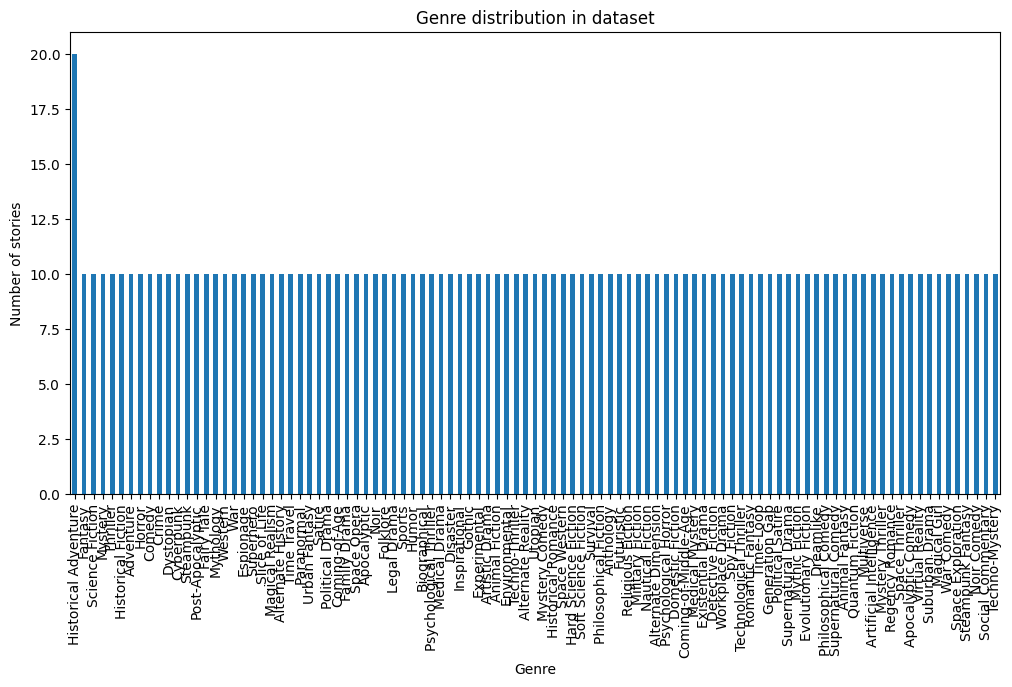

In [ ]:
# List unique genres
unique_genres = df['genre'].sort_values().unique()
num_classes = len(unique_genres)
print(f"Number of unique genres: {num_classes}\n")

# Print each genre and the number of stories in it
print("Number of stories per genre:")
genre_counts = df['genre'].value_counts()
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

#show missing or empty genres
missing_genres = df['genre'].isna().sum()
if missing_genres > 0:
    print(f"\nNumber of stories with missing genre: {missing_genres}")

# visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
genre_counts.plot(kind='bar')
plt.title("Genre distribution in dataset")
plt.xlabel("Genre")
plt.ylabel("Number of stories")
plt.show()


* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [ ]:
df = df[['story_processed', 'genre']]

### Split into train/val/test for later comparison.
* For simplicity.
  -  80% train
  -  10% val
  -  10% test



In [ ]:
from sklearn.model_selection import train_test_split

# Split into train + temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['genre'],
    random_state=42
)

# Split temp into val + test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['genre'],
    random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 800, Val: 100, Test: 100


#### Using Groq Provider to start use different models for Data Augmentation 

In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('groq_key')
client = Groq()

In [ ]:
import time
import random

def call_groq_with_backoff(provider: str, prompt, max_retries=5):
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=provider,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=1000,
                temperature=0.9
            )
            story_text = response.choices[0].message.content
            return story_text
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            wait_time = 2 ** attempt + random.random()  # exponential backoff + jitter
            print(f"Waiting {wait_time:.1f}s before retrying...")
            time.sleep(wait_time)
    raise RuntimeError(f"Failed to get response from {provider} after {max_retries} attempts")

Writing two different prompts to generate more data and avoiding redundant data

In [ ]:
prompt_template_1 = """
You are an expert storyteller.

Write a detailed story in the '{genre}' genre not less than 600 words.

Requirements:
- Create a vivid and immersive setting.
- Develop imaginative main characters with clear personalities.
- Include at least two meaningful supporting characters.
- Structure the story with a clear beginning, rising conflict, climax, and resolution.
- Include realistic dialogues, strong emotions, and dynamic actions.
- Use rich descriptive language.
- Make it feel like a professionally written novel chapter.
- Ensure the story is engaging, coherent, and emotionally impactful.
- don't write a title inside the story, just the story itself.
"""

prompt_template_2 = """
You are a master fiction writer.

Create a unique and compelling story in the '{genre}' genre not less than 600 words.

Instructions:
- Introduce strong and memorable characters.
- Build a compelling plot with meaningful twists and challenges.
- Develop tension gradually and lead to a satisfying ending.
- Describe the setting, character emotions, and interactions in vivid detail.
- Use varied sentence structures and expressive language.
- Ensure the narrative flows smoothly and feels fully developed.
- Make the story immersive, creative, and captivating.
- don't write a title inside the story, just the story itself.
"""


In [ ]:
import time
import pandas as pd

def augment_stories(genres, provider, prompt_template):
    """
    Generate ONE story per genre using ONE provider.
    """

    augmented_data = []

    for genre in genres:
        prompt = prompt_template.format(genre=genre)

        # Generate story via API
        story_text = call_groq_with_backoff(provider, prompt)

        augmented_data.append({
            "genre": genre,
            "story_processed": story_text,
            "provider": provider
        })

        # small delay to avoid rate limits
        time.sleep(2)

    return pd.DataFrame(augmented_data)


In [ ]:
# Providers
provider = "openai/gpt-oss-120b"

In [ ]:
#augmented_df = augment_stories(unique_genres, provider, prompt_template_1)
print(f"Augmented stories generated: {len(augmented_df)}")

Augmented stories generated: 99


In [ ]:
augmented_df

In [ ]:
len(train_augmented)

998

In [ ]:
train_augmented = pd.concat([
    train_augmented[['story_processed', 'genre']],
    augmented_df[['story_processed', 'genre']]
], ignore_index=True)

print(f"Final training dataset size: {len(train_augmented)}")

Final training dataset size: 1097


## Using another data augmentation technique which is paraphrasing the stories.

In [ ]:
import time
import pandas as pd

def paraphrase_stories(
    df,
    story_col="story_processed",
    genre_col="genre",
    model="llama-3.1-8b-instant",
    temperature=1.0,
    max_retries=4,
    sleep_time=2
):
    """
    Robust paraphrasing with:
    - retry handling
    - error logging
    - empty response protection
    - progress printing
    """

    paraphrased_data = []
    total = len(df)

    print(f"🚀 Starting paraphrasing using model: {model}")
    print(f"Total stories: {total}\n")

    for idx, row in df.iterrows():
        story_text = str(row[story_col])
        genre = row[genre_col]

        print(f"[{idx+1}/{total}] Processing genre: {genre}")

        # Truncate long stories
        words = story_text.split()
        if len(words) > 980:
            story_text = " ".join(words[:700])

        paraphrase_prompt = f"""
You are an expert creative writer.

Paraphrase the following story while strictly following these rules:
1. The story's genre must NOT change.
2. Preserve the main story idea, plot structure, and title.
3. You may enhance style, characters, themes, and actions.
4. Do NOT remove key events.
5. Keep the story recognizable.

Original Story:
"{story_text}"

Paraphrased / Enhanced Story:
"""

        rewritten_story = None

        # Retry logic
        for attempt in range(max_retries):
            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": paraphrase_prompt}],
                    temperature=temperature,
                )

                rewritten_story = response.choices[0].message.content.strip()

                # Handle empty outputs
                if not rewritten_story:
                    raise ValueError("Empty response from model")

                break  # success

            except Exception as e:
                print(f"⚠ Attempt {attempt+1} failed: {e}")
                time.sleep(sleep_time)

        # If still failed after retries
        if rewritten_story is None:
            print("❌ Failed permanently. Using original story.\n")
            rewritten_story = story_text  # fallback

        paraphrased_data.append({
            "story": rewritten_story,
            "genre": genre
        })

        time.sleep(sleep_time)

    print("✅ Paraphrasing completed.\n")

    return pd.DataFrame(paraphrased_data)


In [ ]:
#final_train_df = pd.concat([train_augmented, paraphrase_stories_df], ignore_index=True)
print(f"Augmented stories generated: {len(final_train_df)}")

### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [ ]:
from datasets import Dataset, DatasetDict

hf_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_augmented),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

print(hf_dataset)


DatasetDict({
    train: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 1097
    })
    validation: Dataset({
        features: ['story_processed', 'genre', '__index_level_0__'],
        num_rows: 100
    })
    test: Dataset({
        features: ['story_processed', 'genre', '__index_level_0__'],
        num_rows: 100
    })
})


In [ ]:
hf_dataset["validation"] = hf_dataset["validation"].remove_columns(["__index_level_0__"])
hf_dataset["test"] = hf_dataset["test"].remove_columns(["__index_level_0__"])


In [ ]:
print(hf_dataset)

DatasetDict({
    train: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 1097
    })
    validation: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 100
    })
    test: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 100
    })
})


### Saving the dataset to disk for later use in fine-tuning

In [ ]:
# Folder to save dataset
save_folder = "/content/drive/MyDrive/Colab Notebook/datasets/genre_classification"
os.makedirs(save_folder, exist_ok=True)

# Save train, validation, test splits as Parquet
hf_dataset["train"].to_parquet(os.path.join(save_folder, "train.parquet"))
hf_dataset["validation"].to_parquet(os.path.join(save_folder, "validation.parquet"))
hf_dataset["test"].to_parquet(os.path.join(save_folder, "test.parquet"))

print(f"Dataset successfully saved to Google Drive at {save_folder}")

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset successfully saved to Google Drive at /content/drive/MyDrive/Colab Notebook/datasets/genre_classification


### Pushing the dataset to Hugging Face Hub for later use in fine-tuning

In [ ]:
# Save and push to Hugging Face Hub
repo_name = "augmented_genre_stories"  # choose a unique name for your dataset repo
hf_dataset.push_to_hub("Yahia-123/augmented_genre_stories")

print(f"Dataset successfully pushed to Hugging Face Hub: {repo_name}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :  17%|#6        |  524kB / 3.14MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  303kB /  303kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  321kB /  321kB            

Dataset successfully pushed to Hugging Face Hub: augmented_genre_stories


In [6]:
hf_dataset = load_dataset("Yahia-123/augmented_genre_stories")

print(hf_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/531 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/303k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/321k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1097 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 1097
    })
    validation: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 100
    })
    test: Dataset({
        features: ['story_processed', 'genre'],
        num_rows: 100
    })
})


### Testing the dataset by loading it from Hugging Face Hub

In [ ]:
# Access first 5 examples from the train split
train_split = hf_dataset['train'][:5]  # This is a dict of lists
texts = train_split['story_processed']
labels = train_split['genre']

print("Train examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")

# Similarly for validation
val_split = hf_dataset['validation'][:5]
texts = val_split['story_processed']
labels = val_split['genre']

print("\nValidation examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")

# And test
test_split = hf_dataset['test'][:5]
texts = test_split['story_processed']
labels = test_split['genre']

print("\nTest examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")


Train examples:
1: Text: in the year 2234, earth was no longer inhabited by humans. it had been transformed into a vast, lush... Genre ID: Alternate Reality
2: Text: once upon a time in a small town called "mundaneville," a mild-mannered man named mr. patterson live... Genre ID: Comedy
3: Text: once upon a time, in a small town named elmswood, lived a culinary genius named albert. he was not j... Genre ID: Supernatural Comedy
4: Text: once upon a time in the mystical land of eldoria, where magic and wonderment were as real as the sun... Genre ID: Fairy Tale
5: Text: in the heart of a bustling metropolis, the city that never sleeps, a new player had entered the game... Genre ID: Espionage

Validation examples:
1: Text: detective jack thompson was a man who had seen it all. his career in the city's police force had spa... Genre ID: Detective Fiction
2: Text: chapter 1: the shadows of the city the sun had just begun to dip below the horizon, casting a golden... Genre ID: Noir
3: Text: in 

## Load Qwen model for peft training

### Model Name

In [7]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

#### Lora Config

In [ ]:
lora_config = LoraConfig(
    r = 32, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'CAUSAL_LM'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [8]:
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

model

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotar

* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(

In [ ]:
model.print_trainable_parameters()

trainable params: 8,716,288 || all params: 1,552,430,592 || trainable%: 0.5615


### Load the tokenizer

#### Since Qwen pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

#### Update some model configs

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1

### Loop through dataset to measure performance before training/fitting the model
* Use a batch size 32 to kinda vectorize and to avoid memory errors.

### testing the performance of the model before fine-tuning

# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset

#### Formating the dataset for the trainer in order to be in the instruction format expected by the model
* We will use the same format as the one used in pre-training Qwen 2.5 which is instruction format. So we will have an instruction and a response. The instruction will be the story and the response will be the label.

In [ ]:
def format_story_example(example):
    # Build unified instruction-style prompt for genre classification
    prompt = (
        f"### Instruction:\nClassify the genre of this story.\n"
        f"### Input:\n{example['story_processed']}\n"
        f"### Response:\n{example['genre']}"
    )
    return {"text": prompt}

In [ ]:
hf_dataset["train"] = hf_dataset["train"].map(format_story_example)
hf_dataset["validation"] = hf_dataset["validation"].map(format_story_example)

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
hf_dataset["train"]

Dataset({
    features: ['story_processed', 'genre', 'text'],
    num_rows: 1097
})

### Identifiying for the model where to compute the loss to be in the response part of the instruction format
* We will use the label ids to identify where to compute the loss and we will set the rest of the instruction to -100 so that the model doesn't compute loss on it and only computes loss on the response part which is the label ids.

In [ ]:
def tokenize_and_mask(batch):
    encodings = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=1024)
    labels_list = []

    for i, text in enumerate(batch["text"]):
        input_ids = encodings["input_ids"][i]

        # Find where "### Response:" starts
        response_marker = "### Response:"
        idx = text.find(response_marker)
        if idx != -1:
            # exclude "### Response:" from loss
            response_start = len(tokenizer(text[:idx], add_special_tokens=False)["input_ids"])
        else:
            response_start = 0

        labels = input_ids.copy()
        labels[:response_start] = [-100] * response_start  # mask everything before genre label
        labels_list.append(labels)

    encodings["labels"] = labels_list
    return encodings



In [ ]:
hf_dataset["train"] = hf_dataset["train"].map(tokenize_and_mask, batched=True)
hf_dataset["validation"] = hf_dataset["validation"].map(tokenize_and_mask, batched=True)

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# define training args

In [ ]:

output_dir = "./Qwen2.5-1.5B/genre_classification_run"


training_args = TrainingArguments(
    output_dir=output_dir,

    # Training batch size
    per_device_train_batch_size=1,      # Small due to 2.5B model
    gradient_accumulation_steps=16,    # Effective batch size = 16

    # Epochs & learning rate
    num_train_epochs=3,                 # Enough for small dataset
    learning_rate=1e-4,                 # Moderate LR
    warmup_steps=50,                    # Small warmup

    # Logging & evaluation
    logging_steps=10,                   # Frequent logging
    eval_steps=50,                      # Evaluate every 50 steps
    # Checkpointing
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,                 # Keep last 2 checkpoints

    # Mixed precision
    fp16=True,                          # Reduce memory usage and speed up

    # Reproducibility
    seed=42,

    # Reporting to WandB
    report_to="wandb",
    run_name="qwen2.5B_genre_causal_classification",  # W&B run name

    # Evaluation batch size (can be larger than training)
    per_device_eval_batch_size=8,

    # Optional: gradient clipping for stability
    gradient_checkpointing=False,       # Can be True to save memory, but slows down training

)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["validation"],
    args=training_args,
)


Truncating train dataset:   0%|          | 0/1097 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

### Run trainer!

In [ ]:
import time

start_time = time.time()
train_result = trainer.train()
end_time = time.time()

total_time_sec = end_time - start_time
total_time_min = total_time_sec / 60

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


wandb: Detected [groq] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss
10,10.830959
20,10.929263
30,6.882370
40,2.119633
50,0.236137
60,0.056462
70,0.039191
80,0.040481
90,0.049132
100,0.036024


In [ ]:
print(f"Training finished in {total_time_min:.2f} minutes ({total_time_sec:.2f} seconds)")
print(train_result)

Training finished in 43.24 minutes (2594.57 seconds)
TrainOutput(global_step=207, training_loss=1.526382072824211, metrics={'train_runtime': 2592.3031, 'train_samples_per_second': 1.27, 'train_steps_per_second': 0.08, 'total_flos': 2.6671203807657984e+16, 'train_loss': 1.526382072824211})


In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/genre_causallm"

trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/genre_causallm/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/genre_causallm/chat_template.jinja',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/genre_causallm/tokenizer.json')

#### Let's check the results


### Saving the model trainer state and model adapters

#### Saving the adapter model
* Note this doesn't save the entire model. It only saves the adapters.

In [9]:
output_dir = "/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/genre_causallm"

### Now we can load the model and the adapters and test it on the test set to see the performance after fine-tuning.

In [10]:
from peft import PeftModel
import torch

# Load full base model to CPU first (without device_map)

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

# Apply LoRA adapter
model = PeftModel.from_pretrained(model, output_dir)

# Move the combined model to GPU
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer (from base or output dir)
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [11]:
model.config.use_cache = True


## Evaluating the model

In [12]:
import torch
from tqdm import tqdm

model.eval()
device = model.device

predictions = []
true_labels = []

for row in tqdm(hf_dataset["validation"]):

    prompt = (
        "### Instruction:\n"
        "Classify the genre of this story.\n"
        "### Input:\n"
        f"{row['story_processed']}\n"
        "### Response:\n"
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,
            do_sample=False
        )

    # 🔥 CRITICAL FIX — slice only generated tokens
    input_length = inputs["input_ids"].shape[1]
    generated_tokens = outputs[0][input_length:]

    predicted = tokenizer.decode(
        generated_tokens,
        skip_special_tokens=True
    ).strip()

    predicted_label = predicted.split("\n")[0].strip()

    predictions.append(predicted_label)
    true_labels.append(row["genre"])


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


In [13]:
predictions

['atmosphere of anticipation and fear',
 'way to prevent the deaths',
 'stuff of legend . the',
 'before them , isabella',
 'to his people , hailed',
 'Sports',
 'Fantasy',
 "before the heroes' eyes",
 'trials stronger than ever before',
 'Adventure',
 'Space Adventure',
 'Mystery',
 'to the power of courage',
 'Crime Thriller',
 'she was able to leave',
 'as lyra and el',
 'Fantasy',
 'but her dedication to the',
 'refused to let the memory',
 'years that followed, humanity',
 'up to the election ,',
 "accept the entity's offer",
 'felt a pang of loss',
 'enemy or continue fighting alone',
 'Adventure',
 'Disaster',
 'a bomb inside the vault',
 'Science Fiction',
 'AI',
 'continue to inspire generations to',
 'Science Fiction',
 ', extending his hand.',
 'Cyberpunk',
 'been feeding it. the',
 'new era of trust and',
 'the sales team was now',
 'New Earth, the discovery',
 'Legal Drama',
 'of america . he spends',
 "some supported the council '",
 'for generations to come .',
 'acherou

In [14]:
predictions = [p.lower().strip() for p in predictions]
true_labels = [t.lower().strip() for t in true_labels]

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="weighted")
recall = recall_score(true_labels, predictions, average="weighted")
f1 = f1_score(true_labels, predictions, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nDetailed Classification Report:\n")
print(classification_report(true_labels, predictions))


Accuracy: 0.07
Precision: 0.05
Recall: 0.07
F1 Score: 0.05466666666666667

Detailed Classification Report:

                                       precision    recall  f1-score   support

                , extending his hand.       0.00      0.00      0.00         0
               , while also trying to       0.00      0.00      0.00         0
              . doors slammed shut on       0.00      0.00      0.00         0
              a bomb inside the vault       0.00      0.00      0.00         0
            accept the entity's offer       0.00      0.00      0.00         0
              acherous terrain of the       0.00      0.00      0.00         0
                            adventure       0.25      1.00      0.40         1
                                   ai       0.00      0.00      0.00         0
                  alternate dimension       0.00      0.00      0.00         1
                    alternate history       0.00      0.00      0.00         1
                    al

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

### ploting the confusion matrix and the classification report

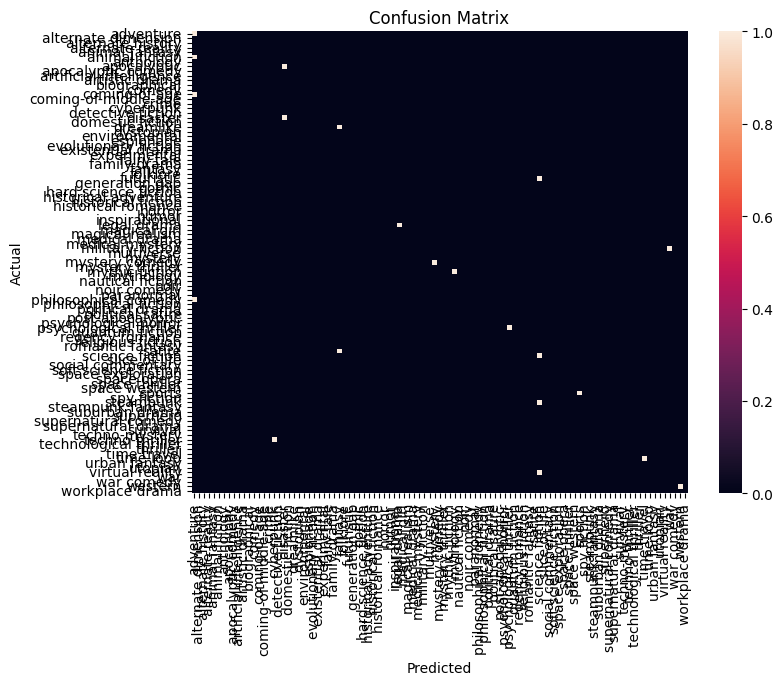

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(list(set(true_labels)))

cm = confusion_matrix(true_labels, predictions, labels=labels)


plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
